In [207]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [208]:
# Load your dataset
data = pd.read_csv('Test.csv')  # Adjust path as necessary

In [209]:
data

,Unnamed: 0,TimeLine,HV_SwitchingFreq_Rail1,VS_Bulk_HvDc,CS_Shunt_HVDC_R1,HV_OutPwr,VS_Vout_Sense_HVDC,MainsRMSCurrent,MainsRMSVoltage
0,0,0.000000,300,154.7,0.08,22.0,279.4,0.0,218.5
1,1,5.032512,300,154.0,0.08,22.0,279.4,0.0,218.5
2,2,10.065025,300,153.4,0.09,22.0,279.4,0.0,218.5
3,3,15.097537,300,339.5,0.09,25.0,279.4,0.5,219.0
4,4,20.130049,300,550.9,0.08,25.0,279.4,0.6,219.0
...,...,...,...,...,...,...,...,...,...
4056,4056,20411.869951,300,686.7,5.00,1394.0,279.4,2.2,219.0
4057,4057,20416.902463,300,688.0,5.00,1397.0,279.4,2.2,219.0
4058,4058,20421.934975,300,687.5,5.00,1397.0,279.8,2.2,219.0
4059,4059,20426.967488,300,688.6,4.99,1396.0,279.4,2.2,219.0


In [210]:
data.drop(columns="Unnamed: 0", inplace=True)

In [211]:
data

,TimeLine,HV_SwitchingFreq_Rail1,VS_Bulk_HvDc,CS_Shunt_HVDC_R1,HV_OutPwr,VS_Vout_Sense_HVDC,MainsRMSCurrent,MainsRMSVoltage
0,0.000000,300,154.7,0.08,22.0,279.4,0.0,218.5
1,5.032512,300,154.0,0.08,22.0,279.4,0.0,218.5
2,10.065025,300,153.4,0.09,22.0,279.4,0.0,218.5
3,15.097537,300,339.5,0.09,25.0,279.4,0.5,219.0
4,20.130049,300,550.9,0.08,25.0,279.4,0.6,219.0
...,...,...,...,...,...,...,...,...
4056,20411.869951,300,686.7,5.00,1394.0,279.4,2.2,219.0
4057,20416.902463,300,688.0,5.00,1397.0,279.4,2.2,219.0
4058,20421.934975,300,687.5,5.00,1397.0,279.8,2.2,219.0
4059,20426.967488,300,688.6,4.99,1396.0,279.4,2.2,219.0


In [212]:
# # Use MinMaxScaler to normalize the data
scal1 = (data['HV_SwitchingFreq_Rail1'][0] - data['HV_SwitchingFreq_Rail1'].to_numpy().min())/(data['HV_SwitchingFreq_Rail1'].to_numpy().max() - data['HV_SwitchingFreq_Rail1'].to_numpy().min())
scal1

1.0

In [213]:
# Use MinMaxScaler to normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['HV_SwitchingFreq_Rail1', 'VS_Bulk_HvDc', 'CS_Shunt_HVDC_R1', 
                                         'HV_OutPwr', 'VS_Vout_Sense_HVDC', 'MainsRMSCurrent', 'MainsRMSVoltage']].values)


# In case sequence_length=3 

In [214]:
scaled_data[0:4]

array([[1.        , 0.19043467, 0.0079602 , 0.0057971 , 0.38513514,
        0.        , 0.        ],
       [1.        , 0.18956283, 0.0079602 , 0.0057971 , 0.38513514,
        0.        , 0.        ],
       [1.        , 0.18881554, 0.00895522, 0.0057971 , 0.38513514,
        0.        , 0.        ],
       [1.        , 0.42060032, 0.00895522, 0.00658762, 0.38513514,
        0.08333333, 0.5       ]])

In [215]:
# X[0] = scaled_data[0:3] 
scaled_data[0:3]

array([[1.        , 0.19043467, 0.0079602 , 0.0057971 , 0.38513514,
        0.        , 0.        ],
       [1.        , 0.18956283, 0.0079602 , 0.0057971 , 0.38513514,
        0.        , 0.        ],
       [1.        , 0.18881554, 0.00895522, 0.0057971 , 0.38513514,
        0.        , 0.        ]])

In [216]:
# Y[0] = scaled_data[3,2]
scaled_data[3,2]

0.008955223880597014

In [217]:
# Prepare the data for LSTM
def create_sequences(data, sequence_length=3):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # 'HV_SwitchingFreq_Rail1' is at index 0
    return np.array(X), np.array(y)


In [218]:
sequence_length = 3  # Example: Use last 50 time steps to predict the next
X, y = create_sequences(scaled_data)
print(X[0])

print(y[0])

[[1.         0.19043467 0.0079602  0.0057971  0.38513514 0.
  0.        ]
 [1.         0.18956283 0.0079602  0.0057971  0.38513514 0.
  0.        ]
 [1.         0.18881554 0.00895522 0.0057971  0.38513514 0.
  0.        ]]
1.0


In [219]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the data to match LSTM input shape (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [220]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Predicting the next voltage value

In [221]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [222]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100)               43200     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


In [223]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
102/102 [==============================] - 2s 7ms/step - loss: 0.0530 - val_loss: 0.0060
Epoch 2/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 3/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0059
Epoch 4/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 5/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 6/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 7/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 8/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 9/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 10/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0063

In [224]:
# Make predictions
predictions = model.predict(X_test)

26/26 [==============================] - 0s 1ms/step


In [225]:
# Reverse the scaling of predictions
# If you are predicting HV_SwitchingFreq_Rail1 (1st column, index 0):
predictions_rescaled = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1)))))



In [226]:
# Evaluate the regression model using MAE, MSE, and R2
mae = mean_absolute_error(y_test, predictions_rescaled[:, 0])
mse = mean_squared_error(y_test, predictions_rescaled[:, 0])
r2 = r2_score(y_test, predictions_rescaled[:, 0])

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 278.7406428065041
Mean Squared Error: 78290.6320736924
R^2 Score: -2930475.668031677


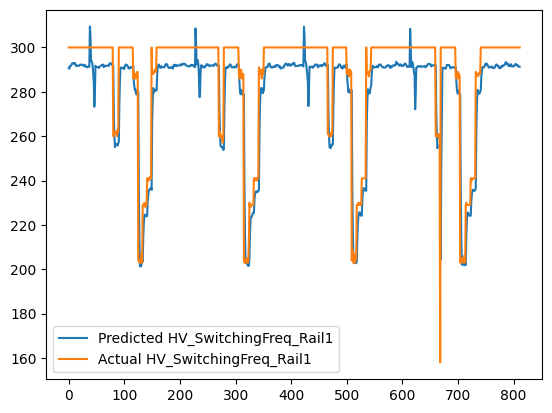

In [227]:
# Plot the results
plt.plot(predictions_rescaled[:, 0], label='Predicted HV_SwitchingFreq_Rail1')
plt.plot(scaler.inverse_transform((np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))))))[:, 0], label='Actual HV_SwitchingFreq_Rail1')
plt.legend()
plt.show()

In [228]:
# Save Model
model.save('my_lstm_model.keras')
model.save("lstm_model.h5")  # Saves the entire model
